In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle

import numpy as np

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
from matplotlib.ticker import FixedLocator, FixedFormatter
mpl.rc_file(f"matplotlibrc")

In [30]:
def get_dc_soln(name):
    return np.load(f'runs/{name}_records.npy', allow_pickle=True).item()
def get_dh_soln(name):
    return pickle.load(open(f'runs/{name}_soln.p', 'rb'))

z_plot_max = 45.
z_plot_min = 5.
dh_soln_test = get_dh_soln('xc_base')
i_z_st_dh = np.argmin(np.abs(dh_soln_test['rs']-1 - z_plot_max))

def plotxy_dc(dc_soln, var):
    z = dc_soln['z']
    if 'dep' in var:
        arr = dc_soln[var] / dc_soln['dE_inj_per_Bavg_unclustered']
    else:
        arr = dc_soln[var]
    return z, arr

def plotxy_dh(dh_soln, var):
    z = dh_soln['rs'] - 1
    if var == 'T_k':
        arr = dh_soln['Tm']/phys.kB
    elif var == 'x_e':
        arr = dh_soln['x'][:, 0]
    elif var == 'dep_heat':
        arr = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
    elif var == 'dep_ion':
        arr = dh_soln['f']['low']['H ion']  + dh_soln['f']['high']['H ion'] \
            + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    elif var == 'dep_exc':
        arr = dh_soln['f']['low']['exc'] + dh_soln['f']['high']['exc']
        
    return z[i_z_st_dh:], arr[i_z_st_dh:]

def blend_white(c, alpha=0.7):
    white = np.array([1., 1., 1.])
    return tuple((1-alpha)*np.array(c) + alpha*white)

def format_xaxis(ax):
    ax.set(xlim=(z_plot_min, z_plot_max), xscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])

In [38]:
from scipy import interpolate

def extrapolate_first_n(z, arr, n):
    interp = interpolate.interp1d(z[n:], arr[n:], kind='linear', bounds_error=False, fill_value='extrapolate')
    arr_first_n = interp(z[:n])
    return z, np.concatenate((arr_first_n, arr[n:]))

In [ ]:
! cp $DM21CM_DIR/outputs/dm21cm/xc/xc_noLX_records.npy runs/

In [10]:
! cp $DM21CM_DIR/outputs/dh/xc_base_soln.p runs/

## 1. No injection: 21cmFAST v. DarkHistory

In [4]:
dc_run_name = 'xc_noLX_nos8_noHe_nosp'
dh_run_name = 'xc_noHe'
save_name = 'xc_noHe_nos8'

In [29]:
dc_run_name = 'xc_noLX'
dh_run_name = 'xc_base'
save_name = 'xc_base'

In [ ]:
# dc_run_name = 'xc_noLX_nos8_noHe_nosp_zf001'
# dh_run_name = 'xc_noHe_zf001'
# save_name = 'xc_noHe_nos8_zf001'
# dc_run_name = 'xc_noLX_noHe_nosp'
# dh_run_name = 'xc_noHe'
# save_name = 'xc_noHe'

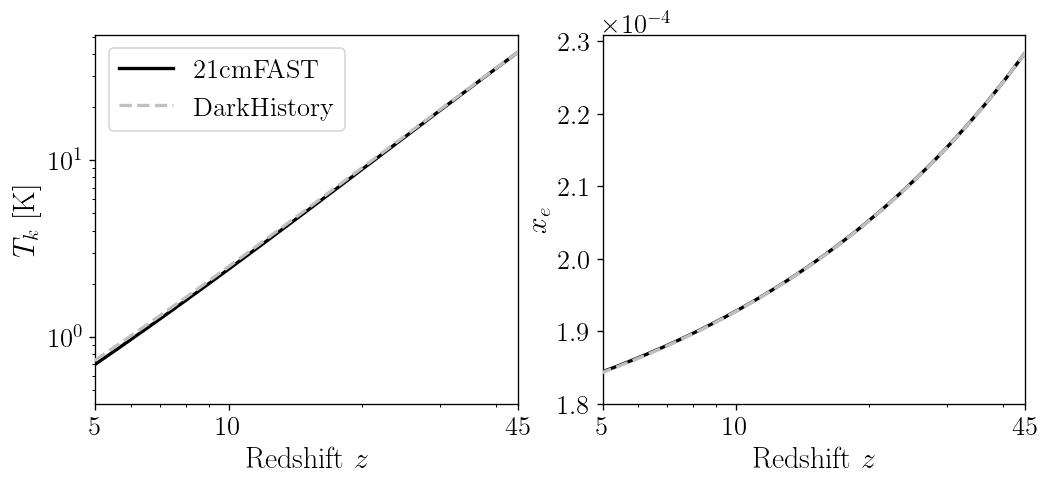

In [30]:
z_plot_max = 45.
z_plot_min = 5.

dc_style = dict(color='k', label='21cmFAST', ls='-', lw=2)
dh_style = dict(color='silver', label='DarkHistory', ls='--', lw=2, zorder=10)

dc_soln = get_dc_soln(dc_run_name)
dh_soln = get_dh_soln(dh_run_name)
i_z_st_dh = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_max))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Tk
ax = axs[0]
ax.plot(*plotxy_dc(dc_soln, 'T_k'), **dc_style)
ax.plot(*plotxy_dh(dh_soln, 'T_k', i_z_st_dh), **dh_style)
ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
ax.set(xlabel='Redshift $z$', ylabel='$T_k$ [K]')
ax.legend()

# x
ax = axs[1]
ax.plot(*plotxy_dc(dc_soln, 'x_e'), **dc_style)
ax.plot(*plotxy_dh(dh_soln, 'x_e', i_z_st_dh), **dh_style)
ax.set(xlim=(z_plot_min, z_plot_max), xscale='log')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
ax.set(xlabel='Redshift $z$', ylabel='$x_e$')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fig.savefig(f'{save_name}.pdf', bbox_inches='tight')

In [ ]:
# relative error: not formatted
z_s = np.linspace(5, 43, 100)
T_21_s = np.interp(z_s, dc_soln['z'][::-1], dc_soln['T_k'][::-1])
T_dh_s = np.interp(z_s, dh_soln['rs'][::-1] - 1, dh_soln['Tm'][::-1]/phys.kB)

x_21_s = np.interp(z_s, dc_soln['z'][::-1], dc_soln['x_e'][::-1])
x_dh_s = np.interp(z_s, dh_soln['rs'][::-1] - 1, dh_soln['x'][::-1, 0])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(z_s, T_dh_s/T_21_s)
axs[1].plot(z_s, x_21_s/x_dh_s)

## 2. Xray: DM21cm-ST vs. DarkHistory-ST

xc_xrayVDH_nos8_noHe_nosp \
xc_xrayVDH_nopop2

In [9]:
dc_run_name_left = 'xc_xray_noLX_nopop2_noHe_nosp'
dh_run_name_left = 'xc_xrayST_noHe'
dc_run_name_right = 'xc_xray_noLX_nopop2'
dh_run_name_right = 'xc_xrayST'
save_name = 'xc_xrayVDH'
# dc_run_name_left = 'xc_xray_noLX_nos8_noHe_nosp'
# dh_run_name_left = 'xc_xrayST_noHe'
# save_name_left = 'xc_xrayVDH_nos8_noHe_nosp'
# dc_run_name_right = 'xc_xray_noLX'
# dh_run_name_right = 'xc_xrayST'
# save_name_right = 'xc_xrayVDH'

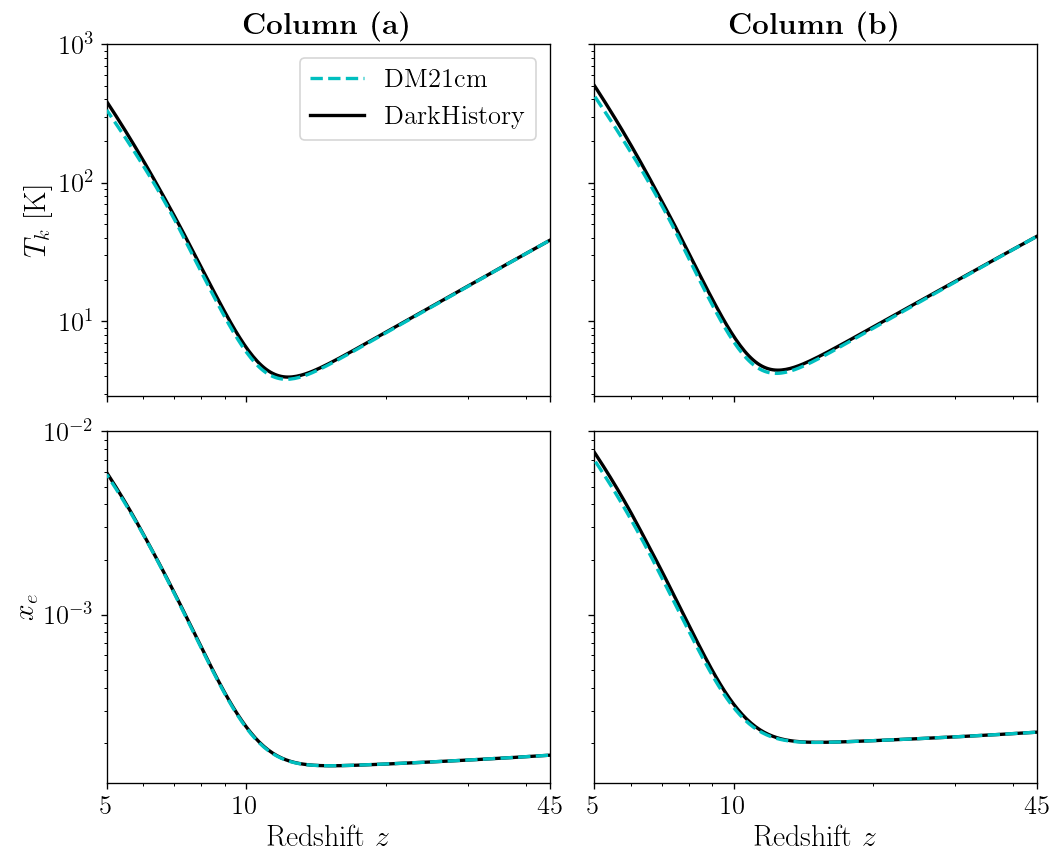

In [10]:
dc_style = dict(color='c', label='DM21cm', ls='--', lw=2, zorder=10)
dh_style = dict(color='k', label='DarkHistory', ls='-', lw=2)

dc_soln = {
    'left' : get_dc_soln(dc_run_name_left),
    'right' : get_dc_soln(dc_run_name_right),
}
dh_soln = {
    'left' : get_dh_soln(dh_run_name_left),
    'right' : get_dh_soln(dh_run_name_right),
}

z_plot_max = 45.
z_plot_min = 5.
i_z_st_dh = np.argmin(np.abs(dh_soln['left']['rs']-1 - z_plot_max))

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex='col', sharey='row')

titles = [r'\textbf{Column (a)}', r'\textbf{Column (b)}']


for i, k in zip([0, 1], ['left', 'right']):

    ax = axs[0,i]
    ax.plot(*plotxy_dc(dc_soln[k], 'T_k'), **dc_style)
    ax.plot(*plotxy_dh(dh_soln[k], 'T_k', i_z_st_dh), **dh_style)
    ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'], ylim=(None, 1e3), title=titles[i])
    if i == 0:
        ax.set(ylabel='$T_k$ [K]')
        ax.legend()

    ax = axs[1,i]
    ax.plot(*plotxy_dc(dc_soln[k], 'x_e'), **dc_style)
    ax.plot(*plotxy_dh(dh_soln[k], 'x_e', i_z_st_dh), **dh_style)
    ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
    if i == 0:
        ax.set(ylabel='$x_e$')
    #ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set(xlabel='Redshift $z$', ylim=(None, 1e-2))

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig(f'{save_name}.pdf', bbox_inches='tight')

## 3. DM: DM21cm vs. DarkHistory

xc_phph_nopop2_lifetime25 \
xc_ee_lifetime26

In [ ]:
# dc_run_name = 'xc_phph_noLX_nos8_noHe_nosp_lifetime25_zf001'
# dh_run_name = 'xc_phph_noHe_lifetime25_zf001'
# save_name = 'xc_phph_nos8_noHe_nosp_lifetime25_zf001'
# dc_run_name = 'xc_phph_noLX_nos8_noHe_nosp_lifetime25'
# dh_run_name = 'xc_phph_noHe_lifetime25'
# save_name = 'xc_phph_nos8_noHe_nosp_lifetime25'
# dc_run_name = 'xc_phph_noLX_nos8_noHe_lifetime25'
# dh_run_name = 'xc_phph_noHe_lifetime25'
# save_name = 'xc_phph_nos8_noHe_lifetime25'
# dc_run_name = 'xc_phph_noLX_nos8_lifetime25'
# dh_run_name = 'xc_phph_lifetime25'
# save_name = 'xc_phph_nos8_lifetime25'
dc_run_name = 'xc_phph_noLX_nopop2_lifetime25'
dh_run_name = 'xc_phph_lifetime25'
save_name = 'xc_phph_nopop2_lifetime25'
# dc_run_name = 'xc_phph_noLX_lifetime25'
# dh_run_name = 'xc_phph_lifetime25'
# save_name = 'xc_phph_lifetime25'

In [ ]:
# dc_run_name = 'xc_ee_noLX_nos8_lifetime26'
# dh_run_name = 'xc_ee_lifetime26'
# save_name = 'xc_ee_nos8_lifetime26'
dc_run_name = 'xc_ee_noLX_lifetime26'
dh_run_name = 'xc_ee_lifetime26'
save_name = 'xc_ee_lifetime26'
# dc_run_name = 'xc_ee_noLX_lifetime26_defaultDH'
# dh_run_name = 'xc_ee_lifetime26'
# save_name = 'xc_ee_lifetime26_defaultDH'

/tmp/ipykernel_352674/773523508.py:14: RuntimeWarning: invalid value encountered in divide
  arr = dc_soln[var] / dc_soln['dE_inj_per_Bavg_unclustered']


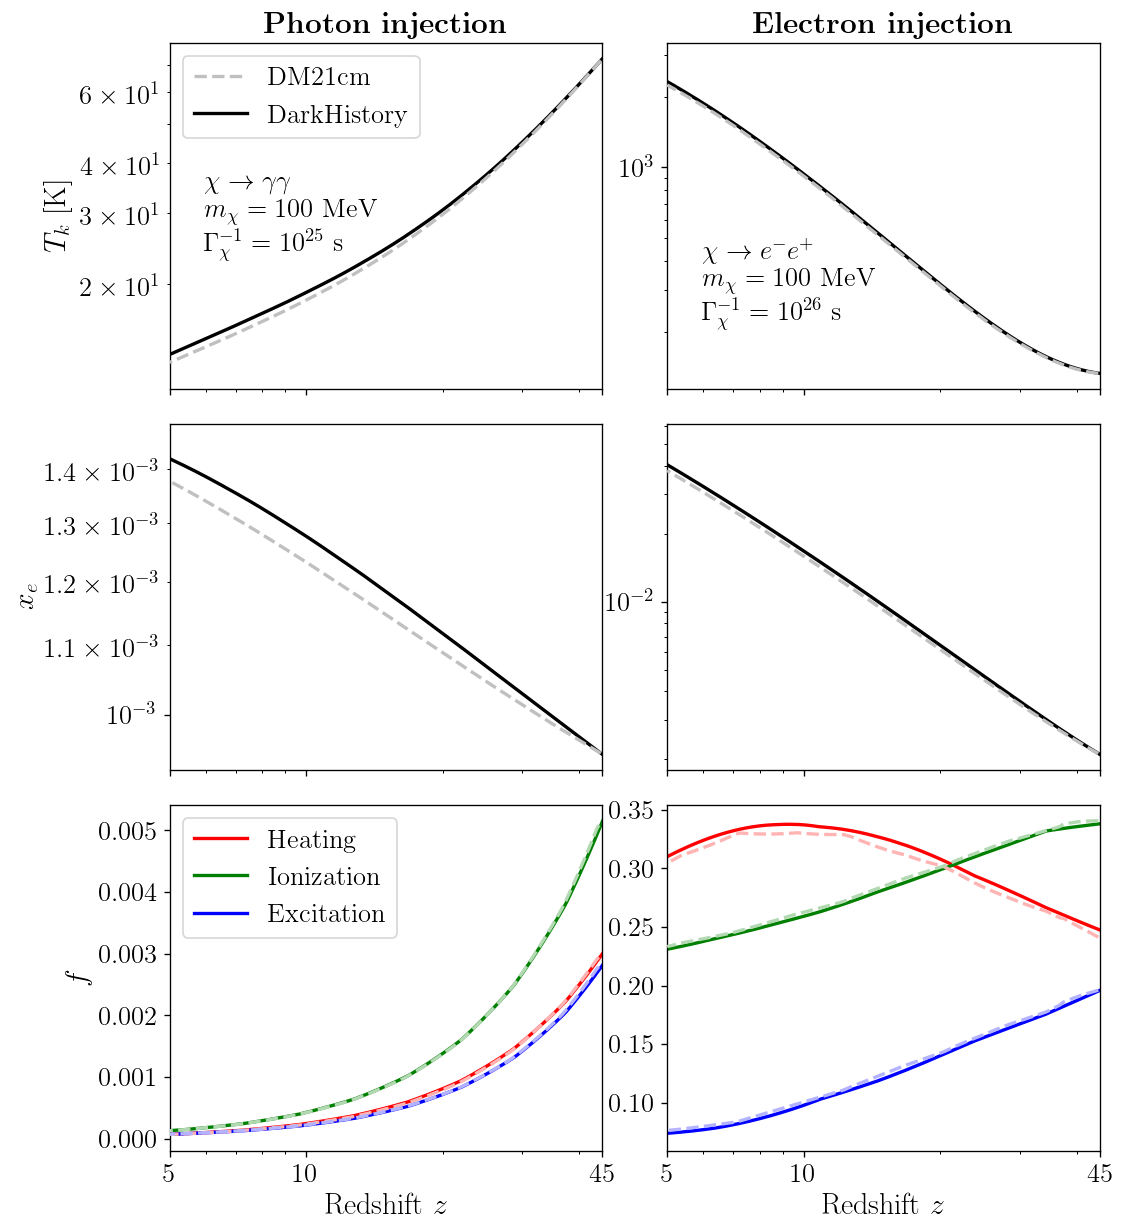

In [43]:
dc_style = dict(color='silver', label='DM21cm', ls='--', lw=2, zorder=10)
dh_style = dict(color='k', label='DarkHistory', ls='-', lw=2)
dc_f_style = dict(ls='--', lw=2, zorder=10)
dh_f_style = dict(ls='-', lw=2)

dc_soln = {
    'left' : get_dc_soln('xc_phph_noLX_nopop2_lifetime25'),
    'right' : get_dc_soln('xc_ee_noLX_lifetime26'),
}
dh_soln = {
    'left' : get_dh_soln('xc_phph_lifetime25'),
    'right' : get_dh_soln('xc_ee_lifetime26'),
}
save_name = 'xc_inj'
titles = [r'\textbf{Photon injection}', r'\textbf{Electron injection}']
textops = {
    'left' : (0.08, 0.4, '$\\chi\\rightarrow\\gamma\\gamma$\n$m_{\\chi}=100~$MeV\n$\\Gamma_{\\chi}^{-1}=10^{25}~$s'), 
    'right' : (0.08, 0.2, '$\\chi\\rightarrow e^-e^+$\n$m_{\\chi}=100~$MeV\n$\\Gamma_{\\chi}^{-1}=10^{26}~$s'),
}
f_colors = {
    'heat' : 'r',
    'ion' : 'g',
    'exc' : 'b',
}
f_labels = {
    'heat' : 'Heating',
    'ion' : 'Ionization',
    'exc' : 'Excitation',
}

fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex='col')

for i, k in zip([0, 1], ['left', 'right']):

    ax = axs[0, i]
    ax.plot(*plotxy_dc(dc_soln[k], 'T_k'), **dc_style)
    ax.plot(*plotxy_dh(dh_soln[k], 'T_k'), **dh_style)
    format_xaxis(ax)
    ax.set(yscale='log', title=titles[i])
    if i == 0:
        ax.set(ylabel='$T_k$ [K]')
        #ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.legend()
    ax.text(*textops[k], transform=ax.transAxes, fontsize=16)

    ax = axs[1, i]
    ax.plot(*plotxy_dc(dc_soln[k], 'x_e'), **dc_style)
    ax.plot(*plotxy_dh(dh_soln[k], 'x_e'), **dh_style)
    format_xaxis(ax)
    ax.set(yscale='log')
    if i == 0:
        ax.set(ylabel='$x_e$')
        #ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax = axs[2, i]
    for f_label in ['heat', 'ion', 'exc']:
        color = mpl.colors.to_rgb(f_colors[f_label])
        z, arr = plotxy_dc(dc_soln[k], 'dep_'+f_label)
        if i == 1:
            z, arr = extrapolate_first_n(z, arr, 5)
        ax.plot(z, arr, color=blend_white(color), **dc_f_style)
        ax.plot(*plotxy_dh(dh_soln[k], 'dep_'+f_label), color=color, label=(f_labels[f_label] if i==0 else None), **dh_f_style)
        format_xaxis(ax)
        if i == 0:
            ax.set(ylabel='$f$')
            ax.legend()
        ax.set(xlabel='Redshift $z$')

fig.subplots_adjust(wspace=0.15, hspace=0.1)
fig.savefig(f'{save_name}.pdf', bbox_inches='tight')

In [ ]:
# relative error: not formatted
z_s = np.linspace(5, 43, 100)
T_21_s = np.interp(z_s, dc_soln['z'][::-1], dc_soln['T_k'][::-1])
T_dh_s = np.interp(z_s, dh_soln['rs'][::-1] - 1, dh_soln['Tm'][::-1]/phys.kB)

x_21_s = np.interp(z_s, dc_soln['z'][::-1], dc_soln['x_e'][::-1])
x_dh_s = np.interp(z_s, dh_soln['rs'][::-1] - 1, dh_soln['x'][::-1, 0])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(z_s, T_dh_s/T_21_s)
axs[1].plot(z_s, x_21_s/x_dh_s)

## 3. Xray: DM21cm vs 21cmFAST

In [ ]:
# dc_run_name = 'xc_xray_noLX_nopop2_nosp_noatten_esf'
# p21c_run_name = 'xc_nopop2_nosp_noatten_esf'
# save_name = 'xc_xrayV21_nopop2_nosp_noatten_esf'
# dc_run_name = 'xc_xray_noLX_nopop2_nosp_noatten'
# p21c_run_name = 'xc_nopop2_nosp_noatten'
# save_name = 'xc_xrayV21_nopop2_nosp_noatten'
dc_run_name = 'xc_xray_noLX_nopop2'
p21c_run_name = 'xc_nopop2'
save_name = 'xc_xrayV21_nopop2'
dc_run_name = 'xc_xray_noLX'
p21c_run_name = 'xc'
save_name = 'xc_xrayV21'
# dc_run_name = 'xc_xray_noLX_nopop2_noHe_nosp_noatten_21totdep_esf'
# p21c_run_name = 'xc_nopop2_noHe_nosp_noatten_esf'
# save_name = 'xc_xrayV21_nopop2_noHe_nosp_noatten_21totdep_esf'
# dc_run_name = 'xc_xray_noLX_xHdep'
# p21c_run_name = 'xc'
# save_name = 'xc_xrayV21_xHdep'
# dc_run_name = 'xc_xray_noLX_xeatten'
# p21c_run_name = 'xc'
# save_name = 'xc_xrayV21_xeatten'

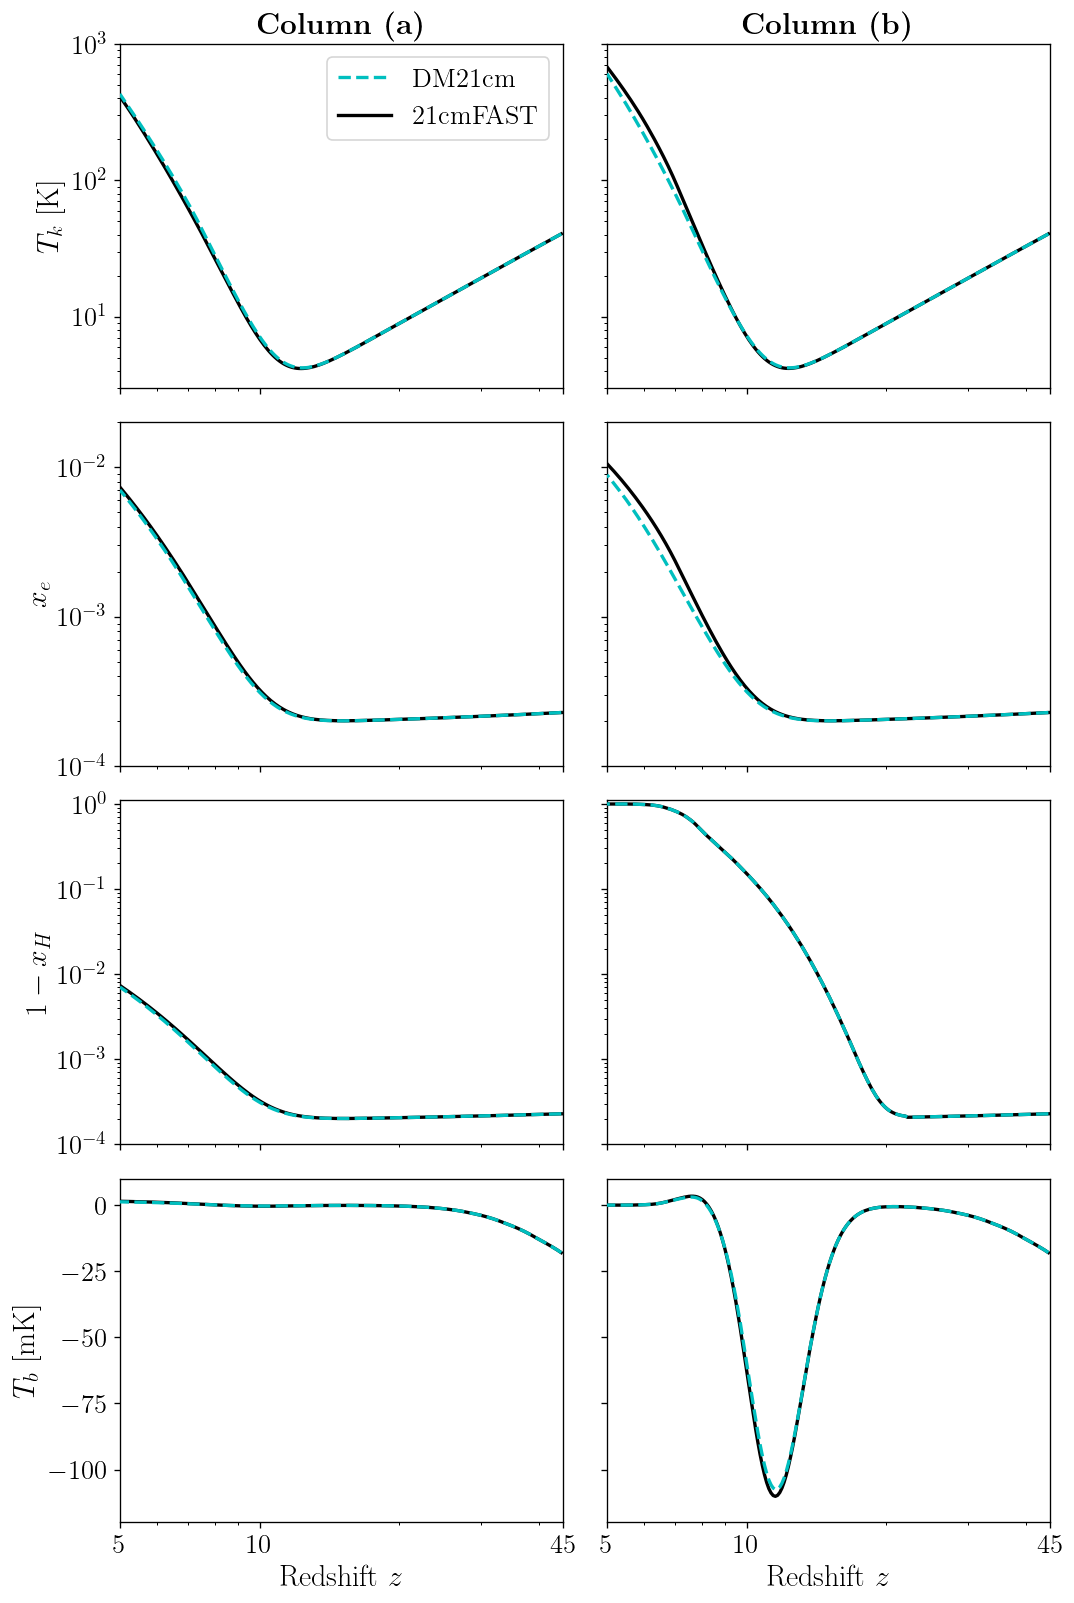

In [28]:
dc_style = dict(color='c', label='DM21cm', ls='--', lw=2, zorder=10)
pc_style = dict(color='k', label='21cmFAST', ls='-', lw=2)

dc_soln = {
    'left' : get_dc_soln('xc_xray_noLX_nopop2'),
    'right' : get_dc_soln('xc_xray_noLX'),
}
pc_soln = {
    'left' : get_dc_soln('xc_nopop2'),
    'right' : get_dc_soln('xc'),
}
save_name = 'xc_xrayV21'

z_plot_max = 45.
z_plot_min = 5.
i_z_st_dh = np.argmin(np.abs(dh_soln['left']['rs']-1 - z_plot_max))

fig, axs = plt.subplots(4, 2, figsize=(10, 16), sharex='col', sharey='row')

titles = [r'\textbf{Column (a)}', r'\textbf{Column (b)}']

for i, k in zip([0, 1], ['left', 'right']):
    ax = axs[0,i]
    ax.plot(*plotxy_dc(dc_soln[k], 'T_k'), **dc_style)
    ax.plot(*plotxy_dc(pc_soln[k], 'T_k'), **pc_style)
    ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
    ax.set(ylim=(3, 1e3), title=titles[i])
    if i == 0:
        ax.set(ylabel='$T_k$ [K]')
        ax.legend()

    ax = axs[1,i]
    ax.plot(*plotxy_dc(dc_soln[k], 'x_e'), **dc_style)
    ax.plot(*plotxy_dc(pc_soln[k], 'x_e'), **pc_style)
    ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
    ax.set(ylim=(1e-4, 2e-2))
    if i == 0:
        ax.set(ylabel='$x_e$')
    

    ax = axs[2,i]
    ax.plot(*plotxy_dc(dc_soln[k], '1-x_H'), **dc_style)
    ax.plot(*plotxy_dc(pc_soln[k], '1-x_H'), **pc_style)
    ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
    ax.set(ylim=(1e-4, 1.1))
    if i == 0:
        ax.set(ylabel='$1-x_H$')
    

    ax = axs[3,i]
    ax.plot(*plotxy_dc(dc_soln[k], 'T_b'), **dc_style)
    ax.plot(*plotxy_dc(pc_soln[k], 'T_b'), **pc_style)
    ax.set(xlim=(z_plot_min, z_plot_max), xscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
    ax.set(ylim=(-120, 10))
    if i == 0:
        ax.set(ylabel='$T_b$ [mK]')
    ax.set(xlabel='Redshift $z$')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig(f'{save_name}.pdf', bbox_inches='tight')

In [ ]:
# relative error: not formatted
z_s = np.linspace(5, 43, 100)
T_dc_s = np.interp(z_s, dc_soln['z'][::-1], dc_soln['T_k'][::-1])
T_p21c_s = np.interp(z_s, p21c_soln['z'][::-1], p21c_soln['T_k'][::-1])

x_dc_s = np.interp(z_s, dc_soln['z'][::-1], dc_soln['x_e'][::-1])
x_p21c_s = np.interp(z_s, p21c_soln['z'][::-1], p21c_soln['x_e'][::-1])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(z_s, T_dc_s/T_p21c_s)
axs[1].plot(z_s, x_dc_s/x_p21c_s)

## A. Xray plots with f

In [ ]:
label_dict = {
    'dc' : 'DM21cm',
    'dh' : 'DarkHistory',
    '21' : '21cmFAST',
    'heat' : 'Heating',
    'exc' : 'Excitation',
    'ion' : 'Ionization',
}
color_dict = {
    'dc' : 'b',
    'dh' : cms['binary'](0.4),
    '21' : 'k',
    'heat' : mpl.colors.to_rgb('r'),
    'exc' : mpl.colors.to_rgb('b'),
    'ion' : mpl.colors.to_rgb('g'),
}
ls_dict = {
    'dc' : '--',
    'dh' : '--',
    '21' : '-',
}

z_plot_max = 45.
z_plot_min = 5.

/tmp/ipykernel_554949/1175195791.py:54: RuntimeWarning: invalid value encountered in divide
  ax.plot(dc_soln['z'], dc_soln['dep_'+f_label]/dc_dep_tot, color=color_dict[f_label], ls=ls_dict['21'], lw=2, label=label_dict[f_label])


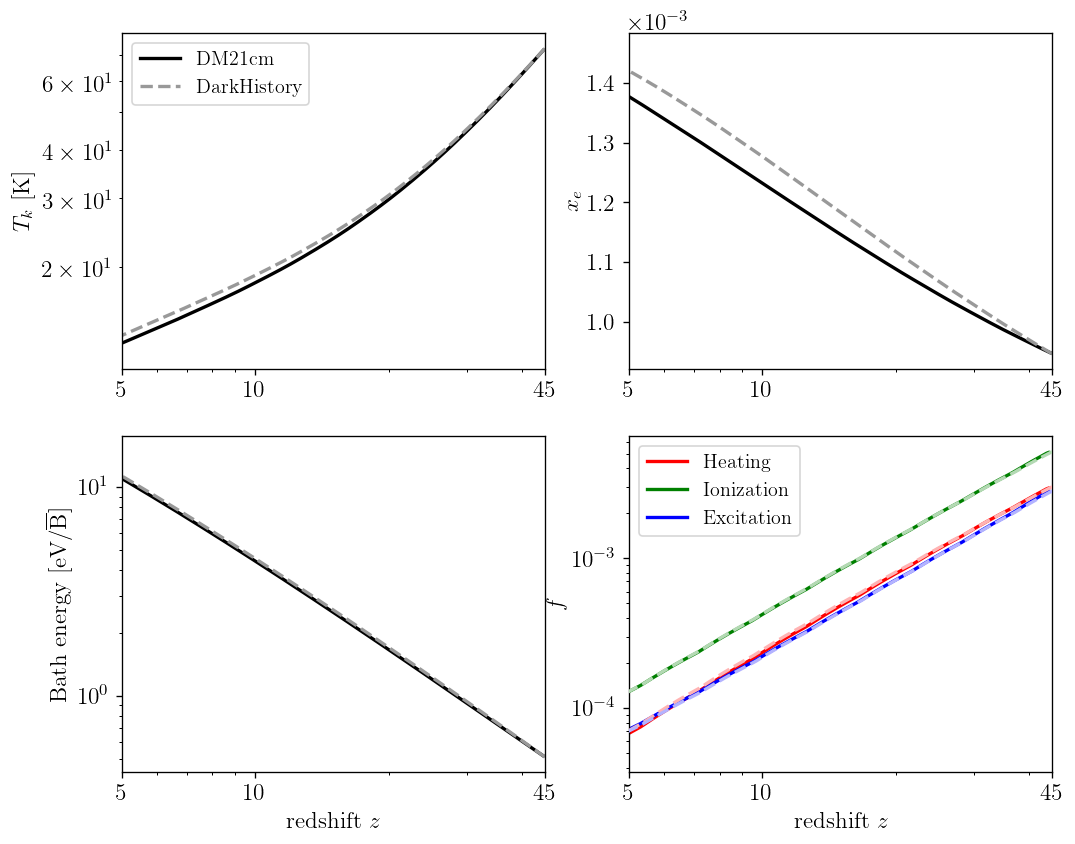

In [ ]:
dc_soln = np.load(f'{WDIR}/outputs/dm21cm/{dc_run_name}_records.npy', allow_pickle=True).item()
dh_soln = pickle.load(open(f'{WDIR}/outputs/dh/{dh_run_name}_soln.p', 'rb'))
i_z_st_dh = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_max))

def blend_white(c, alpha=0.7):
    white = np.array([1., 1., 1.])
    return tuple((1-alpha)*np.array(c) + alpha*white)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Tk
ax = axs[0,0]
ax.plot(dc_soln['z'], dc_soln['T_k'], color=color_dict['dc'], label=label_dict['dc'], ls=ls_dict['dc'], lw=2)
#ax.plot(dc_soln['z'][0], dc_soln['T_k'][0], color=color_dict['21'], marker='+', ms=7, zorder=10)
ax.plot(dh_soln['rs'][i_z_st_dh:] - 1, dh_soln['Tm'][i_z_st_dh:]/phys.kB, color=color_dict['dh'], label=label_dict['dh'], ls=ls_dict['dh'], lw=2)
ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
ax.set(ylabel='$T_k$ [K]')
ax.legend()

# x
ax = axs[0,1]
ax.plot(dc_soln['z'], dc_soln['x_e'], color=color_dict['dc'], label=label_dict['dc'], ls=ls_dict['dc'], lw=2)
#ax.plot(dc_soln['z'][0], dc_soln['x_e'][0], color=color_dict['21'], marker='+', ms=7, zorder=10)
ax.plot(dh_soln['rs'][i_z_st_dh:] - 1, dh_soln['x'][i_z_st_dh:, 0], color=color_dict['dh'], label=label_dict['dh'], ls=ls_dict['dh'], lw=2)
ax.set(xlim=(z_plot_min, z_plot_max), xscale='log')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
ax.set(ylabel='$x_e$')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# bath
ax = axs[1,0]
ax.plot(dc_soln['z'], dc_soln['E_phot'], color=color_dict['dc'], label=label_dict['dc'], ls=ls_dict['dc'], lw=2)
dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
ax.plot(dh_soln['rs'][i_z_st_dh:] - 1, dh_bath_engs[i_z_st_dh:], color=color_dict['dh'], label=label_dict['dh'], ls=ls_dict['dh'], lw=2)
ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
ax.set(xlabel='redshift $z$', ylabel=r'Bath energy [eV/$\overline\mathrm{B}$]')

# f
ax = axs[1,1]
dh_fheat_s = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
dh_fion_s = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
dh_fexc_s = dh_soln['f']['low']['exc'] + dh_soln['f']['high']['exc']
dc_dep_tot = dc_soln['dE_inj_per_Bavg_unclustered']

for f_label, dh_f_s in zip(['heat', 'ion', 'exc'], [dh_fheat_s, dh_fion_s, dh_fexc_s]):
    color = color_dict[f_label]
    ax.plot(dh_soln['rs'][i_z_st_dh:] - 1, dh_f_s[i_z_st_dh:], color=blend_white(color), lw=2, ls='--', zorder=10)
    ax.plot(dc_soln['z'], dc_soln['dep_'+f_label]/dc_dep_tot, color=color_dict[f_label], ls=ls_dict['21'], lw=2, label=label_dict[f_label])
    
ax.set(xlim=(z_plot_min, z_plot_max), xscale='log', yscale='log')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])
ax.set(xlabel='redshift $z$', ylabel=r'$f$')
ax.legend()

fig.savefig(f'{save_name}.pdf', bbox_inches='tight')